In [1]:
# imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os

In [6]:
# load data
dallin_path = "./../data/"
path = dallin_path

# get a list of all the files in the directory
pvss = os.listdir(path)

csvs = []
for pvs in pvss:
    files = os.listdir(os.path.join(path, pvs))
    for file in files:
        if file.endswith(".csv"):
            csvs.append(os.path.join(path, pvs, file))

# load the data
# we have the settings but they don't look that useful
gps = pd.read_csv(csvs[0])
left_gps = pd.read_csv(csvs[1])
right_gps = pd.read_csv(csvs[2])
labels = pd.read_csv(csvs[3])

# Labels

In [30]:
# idk how to read labels
labels.head()

,paved_road,unpaved_road,dirt_road,cobblestone_road,asphalt_road,no_speed_bump,speed_bump_asphalt,speed_bump_cobblestone,good_road_left,regular_road_left,bad_road_left,good_road_right,regular_road_right,bad_road_right
0,1,0,0,0,1,1,0,0,1,0,0,1,0,0
1,1,0,0,0,1,1,0,0,1,0,0,1,0,0
2,1,0,0,0,1,1,0,0,1,0,0,1,0,0
3,1,0,0,0,1,1,0,0,1,0,0,1,0,0
4,1,0,0,0,1,1,0,0,1,0,0,1,0,0


# GPS

In [27]:
gps.head()
# idk exactly what distance_meters or elapsed_time_seconds mean

,timestamp,latitude,longitude,elevation,accuracy,bearing,speed_meters_per_second,provider,battery,distance_meters,elapsed_time_seconds
0,1.577219e+09,-27.717812,-51.098895,948.770836,24.0,159.73294,0.053275,gps,87,0.000000,0.0
10,1.577219e+09,-27.717840,-51.098877,986.167056,4.0,315.85168,0.101402,gps,86,0.306061,1.0
11,1.577219e+09,-27.717840,-51.098877,985.918529,4.0,316.12387,0.056578,gps,86,0.022915,1.0
12,1.577219e+09,-27.717840,-51.098876,985.829575,4.0,316.15497,0.033049,gps,86,0.038035,1.0
13,1.577219e+09,-27.717839,-51.098873,985.567538,4.0,315.31592,0.014423,gps,86,0.357210,2.0


In [28]:
gps.describe()

,timestamp,latitude,longitude,elevation,accuracy,bearing,speed_meters_per_second,battery,distance_meters,elapsed_time_seconds
count,1.458000e+03,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,1.577219e+09,-27.694939,-51.119457,925.209557,4.087791,213.629077,9.343766,82.995885,9.476842,1.034294
std,4.277255e+02,0.011650,0.011296,40.538447,0.644262,95.640711,7.810864,1.274849,8.119713,0.240517
min,1.577219e+09,-27.717845,-51.132691,874.835101,4.000000,1.006545,0.002526,81.000000,0.000000,0.000000
25%,1.577219e+09,-27.701519,-51.128972,888.995484,4.000000,138.297247,4.334018,82.000000,4.356211,1.000000
50%,1.577219e+09,-27.689817,-51.124745,908.203685,4.000000,197.380600,6.554155,83.000000,6.578976,1.000000
75%,1.577220e+09,-27.687075,-51.109971,961.046558,4.000000,317.124672,15.515677,84.000000,16.425724,1.000000
max,1.577220e+09,-27.681820,-51.098860,995.974683,24.000000,359.790700,26.874480,87.000000,82.384473,6.000000


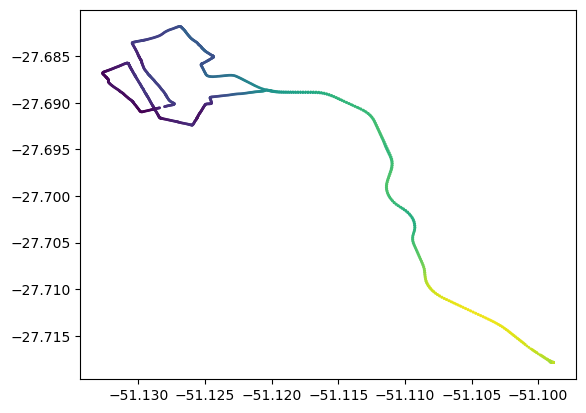

In [18]:
# plot path
plt.scatter(gps['longitude'], gps['latitude'], c=gps['elevation'], cmap='viridis', s=1)
plt.show()

In [26]:
def clean_gps(df):
    bad_cols = ['ageofdgpsdata', "dgpsid", "activity", "annotation"]
    useless_cols = ['hdop', 'vdop', 'pdop', "satellites", "geoidheight"]

    for col in bad_cols + useless_cols:
        if col in df.columns:
            df = df.drop(columns=[col])
    df = df.dropna()
    return df

# Left GPS

In [47]:
left_gps.head()
print(left_gps.columns)

Index(['timestamp', 'acc_x_dash', 'acc_y_dash', 'acc_z_dash', 'acc_x_above',
       'acc_y_above', 'acc_z_above', 'acc_x_below', 'acc_y_below',
       'acc_z_below', 'gyro_x_dash', 'gyro_y_dash', 'gyro_z_dash',
       'gyro_x_above', 'gyro_y_above', 'gyro_z_above', 'gyro_x_below',
       'gyro_y_below', 'gyro_z_below', 'timestamp_gps', 'latitude',
       'longitude', 'speed'],
      dtype='object')


In [48]:
left_gps.describe()

,timestamp,acc_x_dash,acc_y_dash,acc_z_dash,acc_x_above,acc_y_above,acc_z_above,acc_x_below,acc_y_below,acc_z_below,...,gyro_x_above,gyro_y_above,gyro_z_above,gyro_x_below,gyro_y_below,gyro_z_below,timestamp_gps,latitude,longitude,speed
count,1.440360e+05,144036.000000,144036.000000,144036.000000,144036.000000,144036.000000,144036.000000,144036.000000,144036.000000,144036.000000,...,144036.000000,144036.000000,144036.000000,144036.000000,144036.000000,144036.000000,1.440360e+05,144036.000000,144036.000000,144036.000000
mean,1.577220e+09,-0.171308,0.015106,9.719331,-0.101238,0.025862,9.802781,-0.283538,0.107041,9.786143,...,0.111345,0.022507,0.068926,0.008825,-0.020688,0.121456,1.577220e+09,-27.694558,-51.119821,9.556871
std,4.157976e+02,1.399775,1.940585,1.831907,1.290272,1.465464,2.079183,1.876397,5.205432,6.165539,...,3.365533,3.362044,4.285880,9.085235,29.477635,11.714743,4.156529e+02,0.011344,0.011055,7.746386
min,1.577219e+09,-10.735600,-13.446734,-6.418376,-8.855334,-9.940375,-8.353019,-16.605328,-58.305765,-56.387895,...,-26.900129,-21.843515,-23.891542,-69.011507,-207.764217,-127.565293,1.577219e+09,-27.717842,-51.132691,0.002526
25%,1.577219e+09,-0.912191,-0.829292,8.904515,-0.786875,-0.693968,8.805027,-1.124420,-1.694867,7.221254,...,-1.356916,-1.717172,-1.278017,-4.344759,-14.496395,-4.518418,1.577219e+09,-27.700008,-51.129011,4.508887
50%,1.577220e+09,-0.102951,0.090082,9.754456,-0.044672,0.091330,9.779467,-0.205046,0.180990,9.804598,...,0.077410,0.052848,-0.026796,-0.011262,-0.015804,0.059219,1.577220e+09,-27.689739,-51.124897,6.618945
75%,1.577220e+09,0.543484,0.839467,10.522995,0.568243,0.724596,10.779046,0.564690,1.903618,12.356817,...,1.526995,1.731314,1.193907,4.444304,14.098576,4.728408,1.577220e+09,-27.687054,-51.110978,16.647470
max,1.577220e+09,9.033323,14.258967,24.665544,8.924007,13.259439,24.333819,14.990952,69.228569,65.335711,...,26.505633,23.322501,29.575255,122.944060,313.964299,147.367568,1.577220e+09,-27.681820,-51.098863,26.874480


In [45]:
def clean_acc(left, right):
    useless_cols = ["temp_dash", "temp_above", "temp_below"]
    for col in useless_cols:
        if col in left.columns:
            left = left.drop(columns=[col])
        if col in right.columns:
            right = right.drop(columns=[col])
    
    for col in left.columns:
        if "mag" in col:
            left = left.drop(columns=[col])
    for col in right.columns:
        if "mag" in col:
            right = right.drop(columns=[col])
    
    # remove the word "suspect" from the columns
    left.columns = left.columns.str.replace("_suspension", "")
    right.columns = right.columns.str.replace("_suspension", "")
    left.columns = left.columns.str.replace("dashboard", "dash")
    right.columns = right.columns.str.replace("dashboard", "dash")

    left = left.dropna()
    right = right.dropna()
    
    return left, right

In [46]:
left_gps, right_gps = clean_acc(left_gps, right_gps)

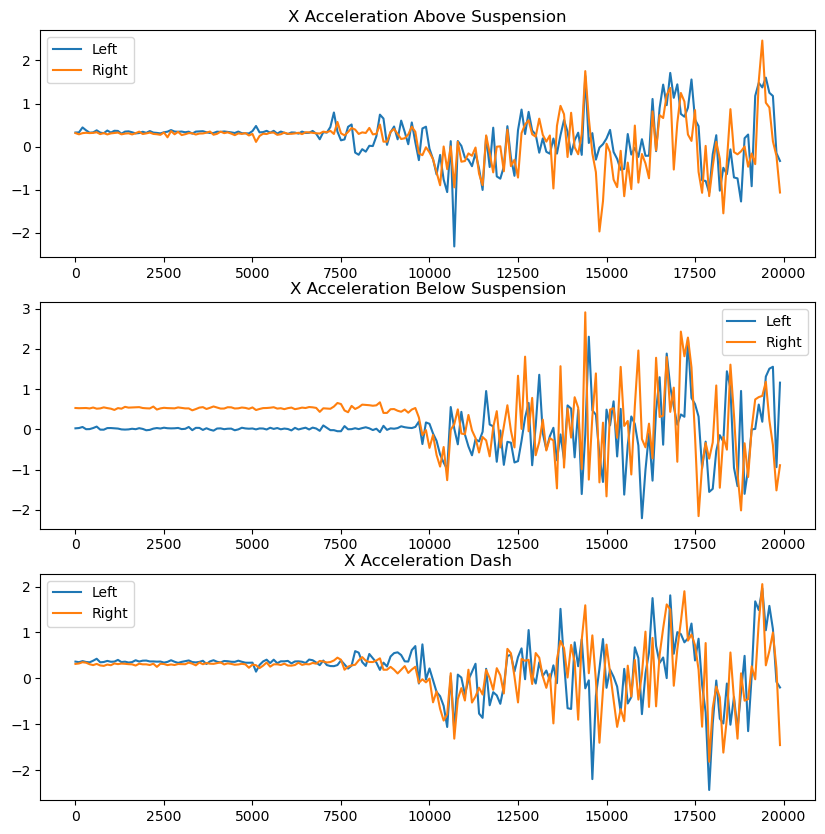

In [66]:
# plot x acceleration
plt.figure(figsize=(10, 10))
sep = 100
end = 20000
plt.subplot(3, 1, 1)
plt.plot(left_gps["acc_x_above"][:end][::sep])
plt.plot(right_gps["acc_x_above"][:end][::sep])
plt.title("X Acceleration Above Suspension")
plt.legend(["Left", "Right"])

plt.subplot(3, 1, 2)
plt.plot(left_gps["acc_x_below"][:end][::sep])
plt.plot(right_gps["acc_x_below"][:end][::sep])
plt.title("X Acceleration Below Suspension")
plt.legend(["Left", "Right"])

plt.subplot(3, 1, 3)
plt.plot(left_gps["acc_x_dash"][:end][::sep])
plt.plot(right_gps["acc_x_dash"][:end][::sep])
plt.title("X Acceleration Dash")
plt.legend(["Left", "Right"])
plt.show()

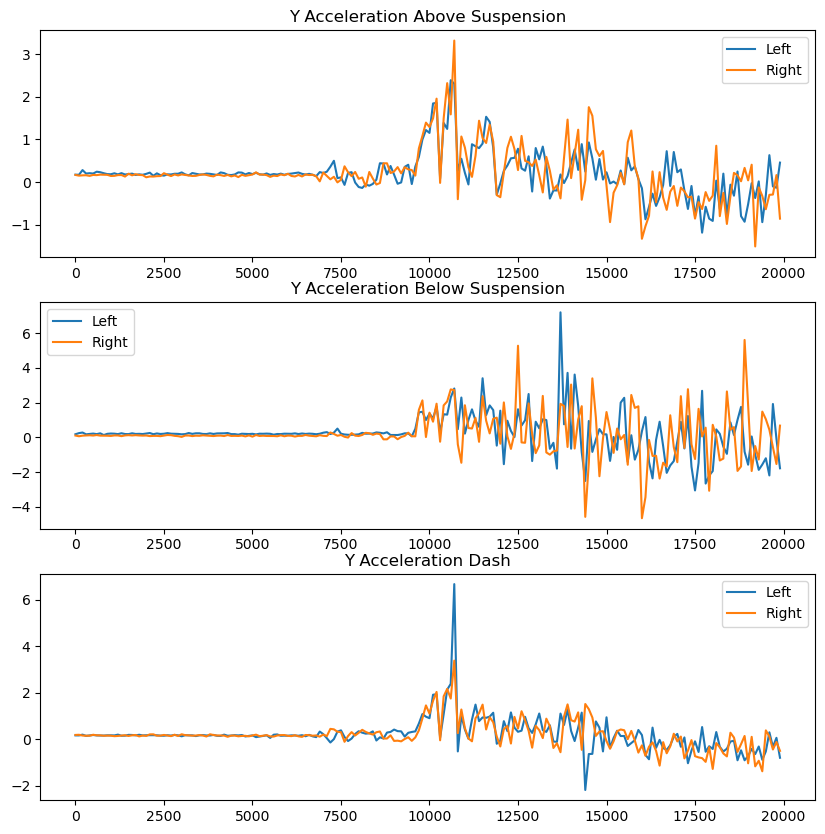

In [65]:
# plot y acceleration
plt.figure(figsize=(10, 10))
sep = 100
end = 20000
plt.subplot(3, 1, 1)
plt.plot(left_gps["acc_y_above"][:end][::sep])
plt.plot(right_gps["acc_y_above"][:end][::sep])
plt.title("Y Acceleration Above Suspension")
plt.legend(["Left", "Right"])

plt.subplot(3, 1, 2)
plt.plot(left_gps["acc_y_below"][:end][::sep])
plt.plot(right_gps["acc_y_below"][:end][::sep])
plt.title("Y Acceleration Below Suspension")
plt.legend(["Left", "Right"])

plt.subplot(3, 1, 3)
plt.plot(left_gps["acc_y_dash"][:end][::sep])
plt.plot(right_gps["acc_y_dash"][:end][::sep])
plt.title("Y Acceleration Dash")
plt.legend(["Left", "Right"])
plt.show()

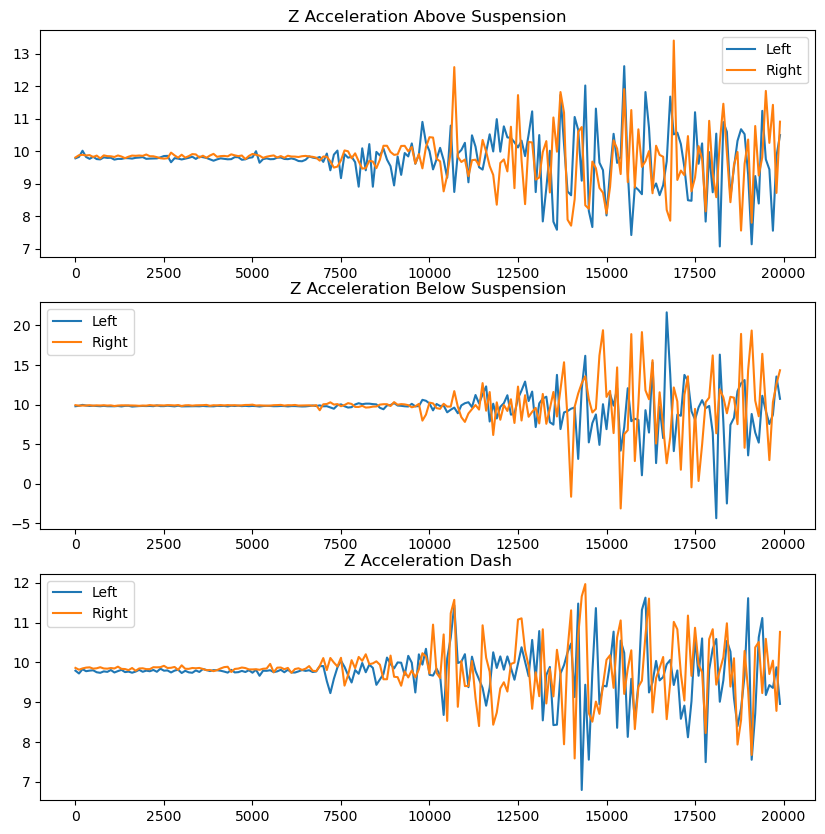

In [67]:
# plot y acceleration
plt.figure(figsize=(10, 10))
sep = 100
end = 20000
plt.subplot(3, 1, 1)
plt.plot(left_gps["acc_z_above"][:end][::sep])
plt.plot(right_gps["acc_z_above"][:end][::sep])
plt.title("Z Acceleration Above Suspension")
plt.legend(["Left", "Right"])

plt.subplot(3, 1, 2)
plt.plot(left_gps["acc_z_below"][:end][::sep])
plt.plot(right_gps["acc_z_below"][:end][::sep])
plt.title("Z Acceleration Below Suspension")
plt.legend(["Left", "Right"])

plt.subplot(3, 1, 3)
plt.plot(left_gps["acc_z_dash"][:end][::sep])
plt.plot(right_gps["acc_z_dash"][:end][::sep])
plt.title("Z Acceleration Dash")
plt.legend(["Left", "Right"])
plt.show()